In [1]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
from bisect import bisect
import eddington
import math
plt.rcParams['figure.figsize'] = [14,7]
plt.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
par = pd.read_excel('AMR - par - 16.xlsx')
perp = pd.read_excel('AMR - Perp - 28.xlsx')
trans = pd.read_excel('AMR - Transverse - 35.xlsx')

In [2]:
def equaliser(x,y,xmin,xmax,start,nun):
    if min(x)<-500 and max(x)<500: # Not a good general solution
        xmax = -start
    else:
        xmin = start
    eq_x = np.linspace(max(x[0],xmin),min(x[-1],xmax),nun)
    eq_y = []
    for point in eq_x:
        i = bisect(x,point)
        if i == len(x):
            eq_y.append(y[i-1])
            continue
        eq_y.append((y[i]-y[i-1])/(x[i]-x[i-1])*(point-x[i-1]) + y[i-1]) 
        # an interpolation function can be written instead to use more advanced interpolation methods
    return eq_x , eq_y

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def Symmon(xy):
    sym = np.array([np.hstack((xy[0][0],xy[1][0])),
                         0.5*np.sign(sum(xy[1][1]+xy[0][1][::-1]))*np.hstack((xy[1][1][::-1]+xy[0][1],xy[1][1]+xy[0][1][::-1]))])
    anti_sym = np.array([np.hstack((xy[0][0],xy[1][0])),
                         0.5*np.sign(sum(xy[1][1]-xy[0][1][::-1]))*np.hstack((-xy[1][1][::-1]+xy[0][1],xy[1][1]-xy[0][1][::-1]))])
    return anti_sym, sym

def AMR_Analysis(name, x, y, time, wind=6, num = 1000 ,start = 200, hmax = 4100):
    timeAndR = eddington.FittingData(dict(x = time, dx = np.zeros_like(time) + 0.001,\
                                               y = y, dy = np.zeros_like(y) + 0.0001))
    temp = eddington.fit(timeAndR,eddington.linear)
    print(temp)
    eddington.plot_fitting(eddington.linear, timeAndR, dict(a = temp.a), title_name='Plot')
    plt.savefig(f'AMR/{name}_Temp_Lin.png')
    plt.show()
#     y = y - temp.a[1]*time


    mun = 1
    i=0
    xys = []
    while i < len(x)-wind:
        temp=[[],[]]
        direction = sum([np.sign(x[i+j+1]-x[i+j]) for j in range(wind)])/wind
        if np.abs(direction) == 1 and (x[i] < -start or start < x[i]):
            direction = int(direction)
            while i < len(x)-2 and (np.sign(x[i+2]-x[i]) == direction):
                temp[0].append(x[i])
                temp[1].append(y[i])
                i+=1

            temp[0] = temp[0][::direction]
            temp[1] = temp[1][::direction]
            if min(temp[0])<-500 and max(temp[0])>500:
                temp = np.array(temp)

                plt.plot(moving_average(temp[0],n=7),moving_average(temp[1],n=7))

                tempL = temp[:,:bisect(temp[0],0)].tolist()
                tempR = temp[:,bisect(temp[0],0):].tolist()
                tempR[0], tempR[1] = equaliser(tempR[0], tempR[1],-hmax,hmax,start,num)
                tempL[0], tempL[1] = equaliser(tempL[0], tempL[1],-hmax,hmax,start,num)
                tempR = np.array(tempR)
                tempL = np.array(tempL)
                xys.append(np.array([tempL,tempR]))

                plt.plot(moving_average(np.hstack((tempL[0],tempR[0])),n=40),moving_average(np.hstack((tempL[1],tempR[1])),n=40))
                plt.savefig(f'AMR/{name}_Inter_{mun}.png')
                mun+=1
                plt.show()
            else:
                plt.plot(temp[0],temp[1])
                temp[0], temp[1] = equaliser(temp[0], temp[1],-hmax,hmax,start,num)
                plt.plot(temp[0],temp[1])
        i+=1
        if sum(temp[0]) > 0 and direction < 0 and min(temp[0])>-500:
            xys.append([np.array([np.nan,np.nan]),np.array(temp)])
        if sum(temp[0]) < 0 and direction < 0 and len(xys) > 0:
            xys[-1][0] = np.array(temp)

        if sum(temp[0]) < 0 and direction > 0 and max(temp[0])<500:
            xys.append([np.array(temp),np.array([np.nan,np.nan])])
        if sum(temp[0]) > 0 and direction > 0 and len(xys) > 0:
            xys[-1][1] = np.array(temp)

    plt.savefig(f'AMR/{name}_Inter_{mun}.png')
    mun+=1
    plt.show()
    return xys

def showSAS(xys, name):
    mun = 0 
    for xy in xys:
        if xy[1].size != xy[0].size:
            continue

        anti_sym, sym = Symmon(xy)
        plt.plot(anti_sym[0],anti_sym[1])
        plt.savefig(f'AMR/{name}_AntiSym_{mun}.png')
        plt.show()
        plt.plot(sym[0],sym[1])
        plt.savefig(f'AMR/{name}_Sym_{mun}.png')
        plt.show()
        mun+=1
        
def inn(x,lst):
    return (x < lst[1]) and (x>lst[0])

def findRegions(x,y,regions):
    Regs = []
    indices = [0,0]
    for j in range(len(regions)):
        reg = np.array([inn(x[i],regions[j])*np.sign(x[i+1]-x[i]) for i in range(len(x)-1)], dtype=int)
        i=0
        temp = []
        if reg[0]!=0:
            while i < len(reg)-1 and reg[i]!=reg[i+1]:
                i+=1
            temp.append([0,i,reg[0], j])
        
        while i < len(reg)-1:
            if reg[i]!=reg[i+1]:
                if indices == [0,0]:
                    indices[0] = i
                else:
                    indices[1] = i
                    if reg[i]:
                        temp.append(indices + [reg[i], j])
                    
                    if reg[i+1]:
                        indices = [i+1,0]
                    else:
                        indices=[0,0]
            i+=1
        Regs.append(temp)
    
    return Regs

def Edwardo(x,y,region,dx=0.001,dy=0.001):
    region = [int(reg) for reg in region]
    data = eddington.FittingData(dict(x = x[region[0]:region[1]], dx = np.zeros_like(x[region[0]:region[1]]) + dx,\
                                      y = y[region[0]:region[1]], dy = np.zeros_like(y[region[0]:region[1]]) + dy))
    fit = eddington.fit(data,eddington.linear)
    return fit.a

def middle(x,n):
    end = len(x)-n//2
    start = n//2
    return x[start:end]

Results:

Initial parameters' values:
	1.0 1.0
Fitted parameters' values:
	a[0] = 2.322926832e+2 ± 5.596e-4 (2.409e-4% error)
	a[1] = -8.19680e-5 ± 9.264e-7 (1.130% error)
Fitted parameters covariance:
[[ 3.815e-11 -5.468e-14]
 [-5.468e-14  1.046e-16]]
Chi squared: 8.578e+6
Degrees of freedom: 1045
Chi squared reduced: 8.208e+3
P-probability: 0.000



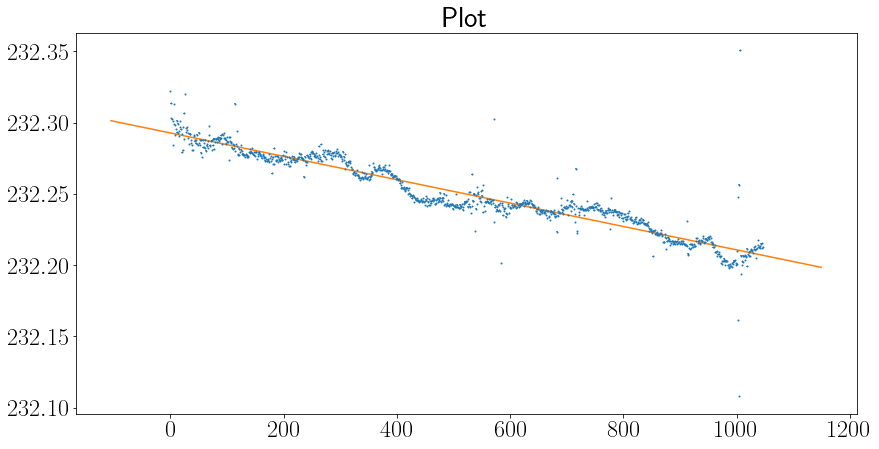

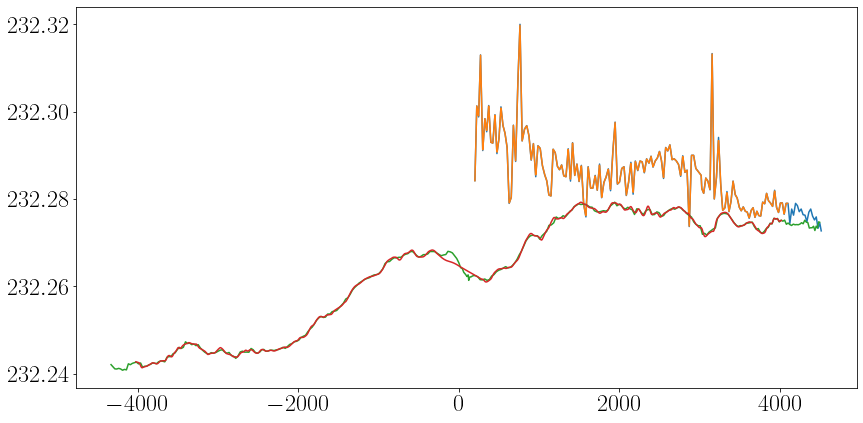

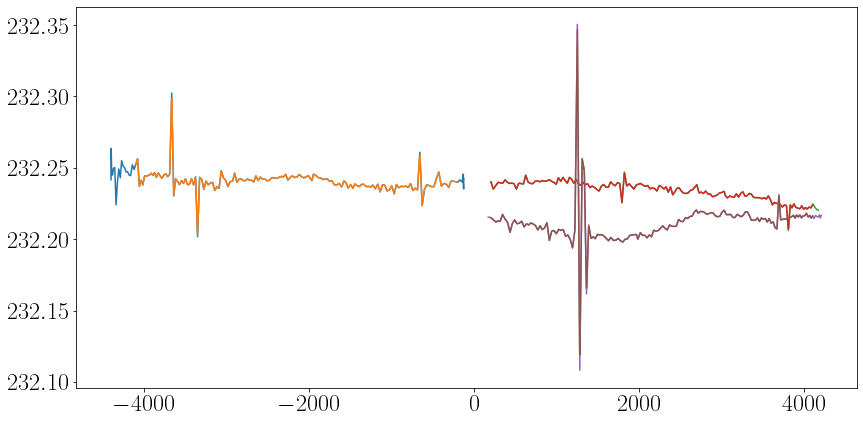

Results:

Initial parameters' values:
	1.0 1.0
Fitted parameters' values:
	a[0] = 2.2757427e+2 ± 0.01465 (6.436e-3% error)
	a[1] = 1.42191e-3 ± 3.289e-5 (2.313% error)
Fitted parameters covariance:
[[ 5.172e-11 -1.006e-13]
 [-1.006e-13  2.609e-16]]
Chi squared: 3.194e+9
Degrees of freedom: 770
Chi squared reduced: 4.148e+6
P-probability: 0.000



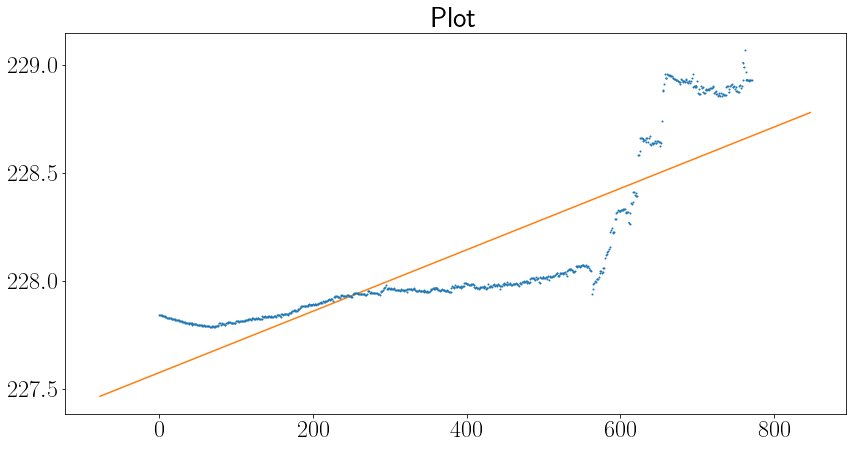

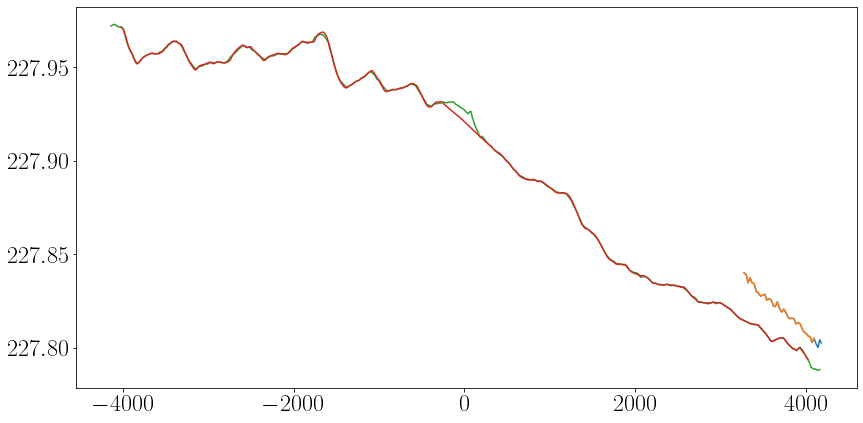

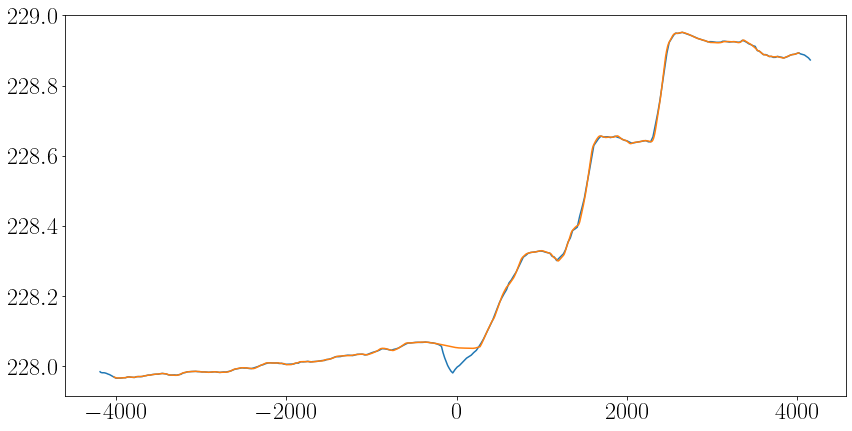

<Figure size 1008x504 with 0 Axes>

Results:

Initial parameters' values:
	1.0 1.0
Fitted parameters' values:
	a[0] = 2.34783217e+2 ± 6.001e-3 (2.556e-3% error)
	a[1] = -1.37947e-4 ± 9.507e-6 (6.892% error)
Fitted parameters covariance:
[[ 3.651e-11 -5.009e-14]
 [-5.009e-14  9.165e-17]]
Chi squared: 1.077e+9
Degrees of freedom: 1092
Chi squared reduced: 9.862e+5
P-probability: 0.000



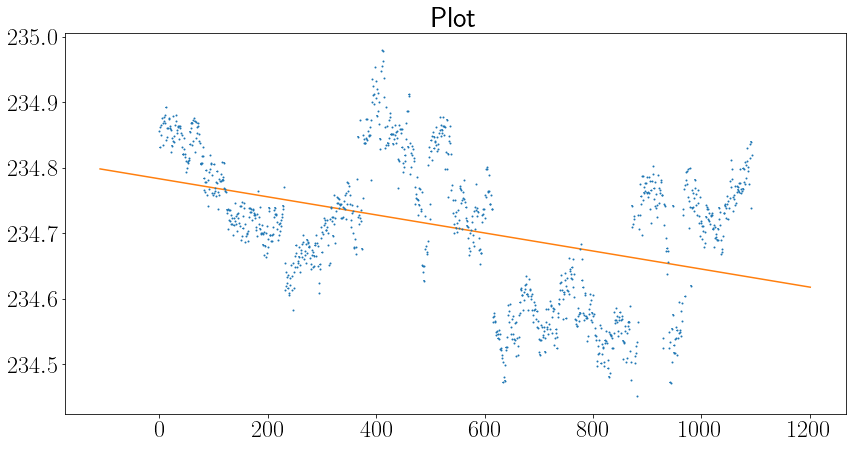

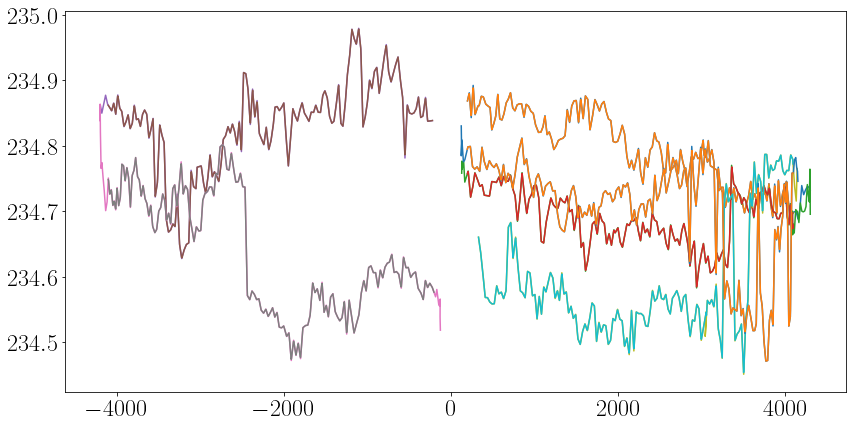

In [3]:
xysPar = AMR_Analysis('Par', par['H [Gauss]'].to_numpy(), par['R [kOhm]'].to_numpy(),par.index.to_numpy()) # Lists of Left and Right sides
xysPerp = AMR_Analysis('Perp', perp['H [Gauss]'].to_numpy(), perp['R [kOhm]'].to_numpy(), perp.index.to_numpy())
xysTrans = AMR_Analysis('Trans', trans['H [Gauss]'].to_numpy(), trans['R [kOhm]'].to_numpy(),trans.index.to_numpy())

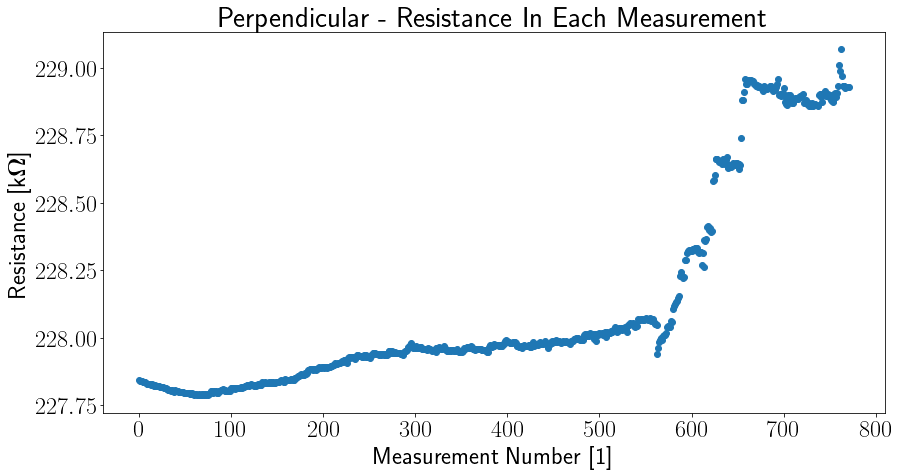

In [25]:
plt.scatter(perp.index, perp['R [kOhm]'])
plt.title('Perpendicular - Resistance In Each Measurement')
plt.ylabel(r'Resistance [k$\boldsymbol\Omega$]')
plt.xlabel('Measurement Number [1]')
plt.savefig('Graphs/AMR-PerpVsTime.png')
plt.show()

Parallel:


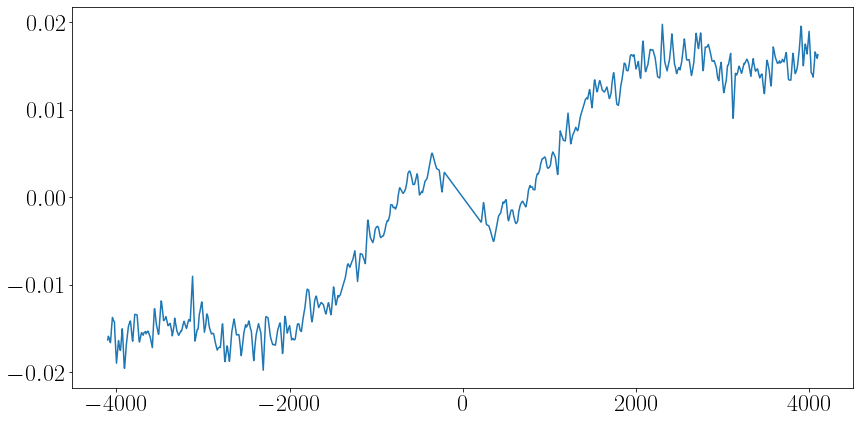

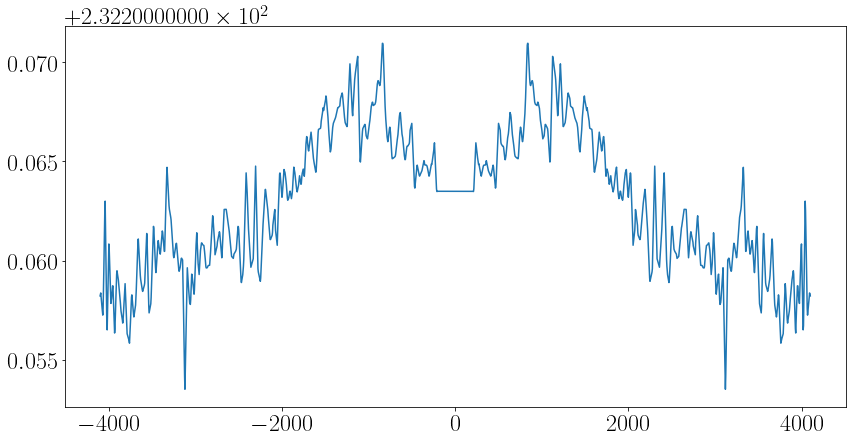

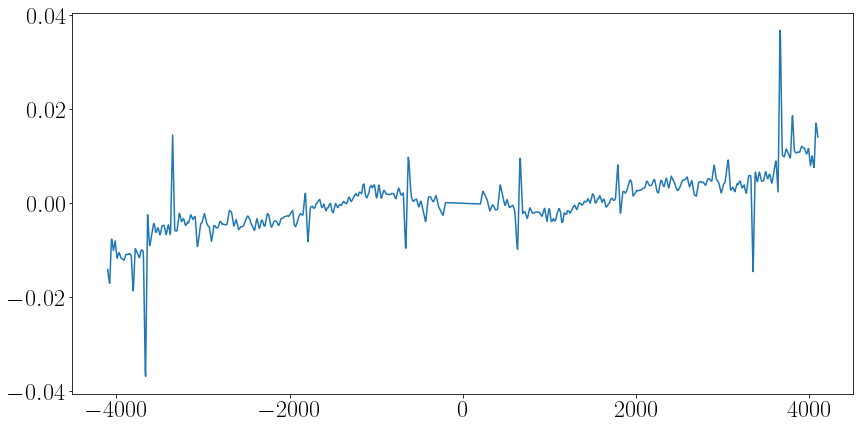

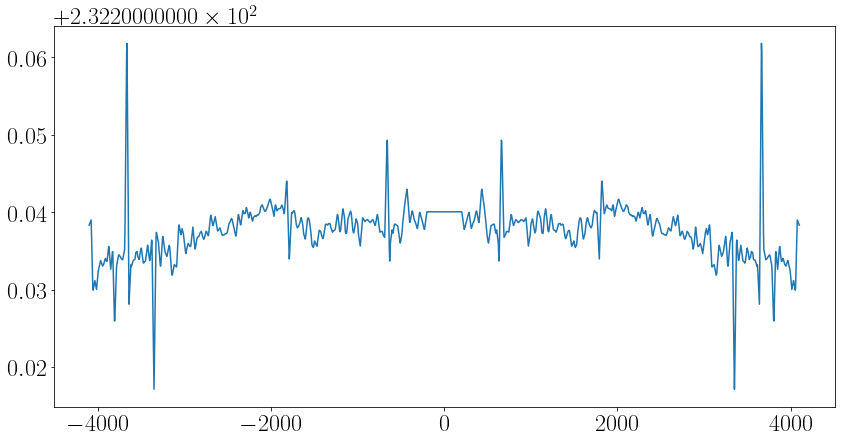

Pependicular:


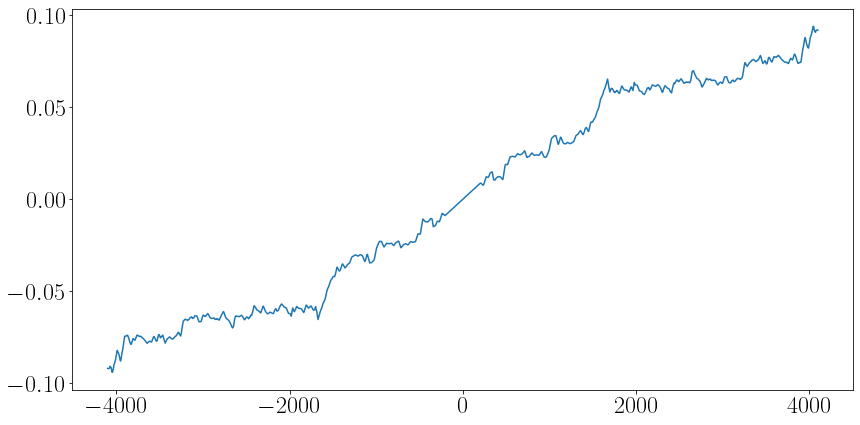

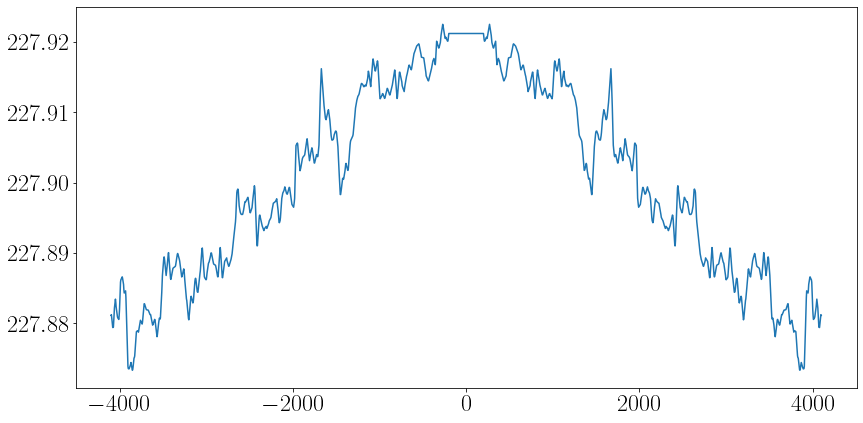

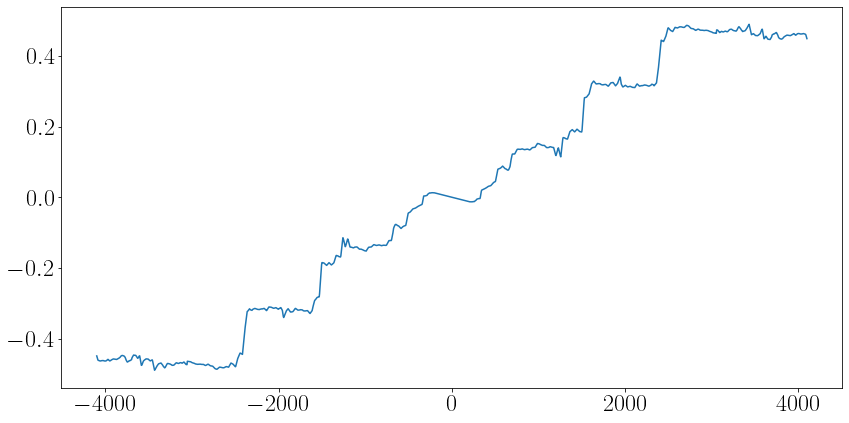

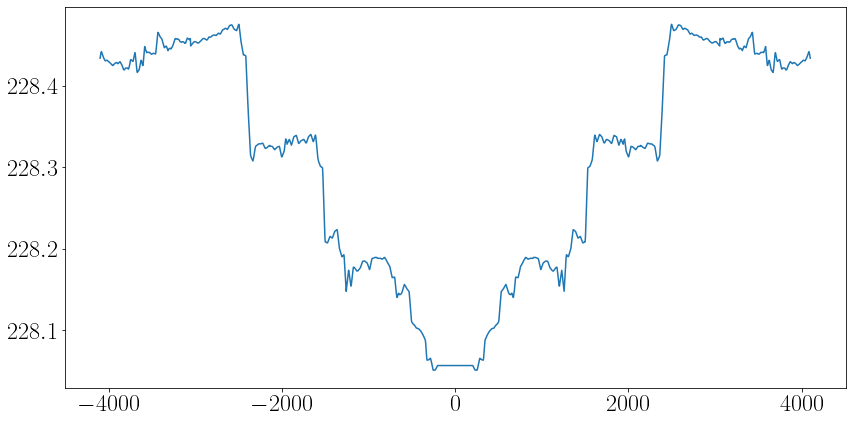

Transverse:


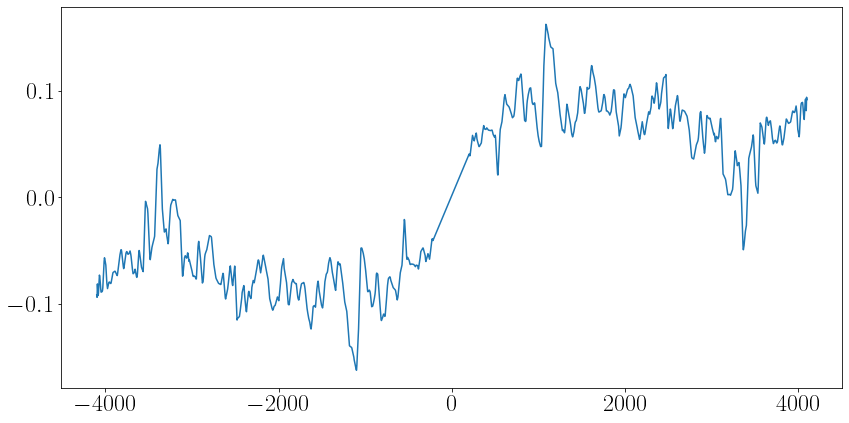

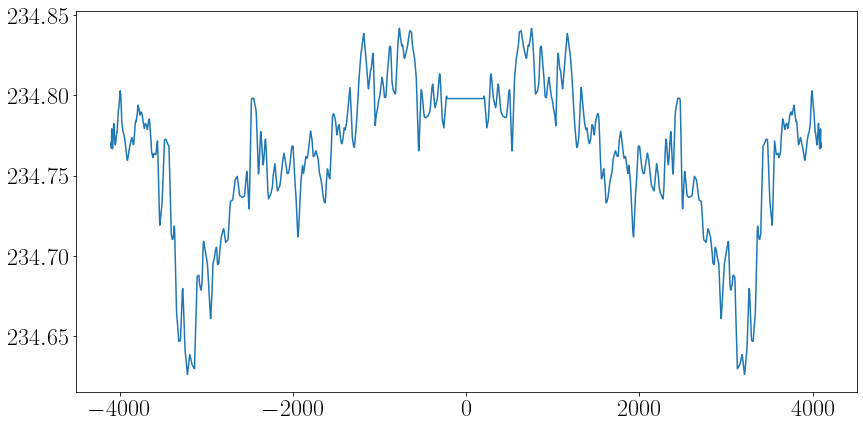

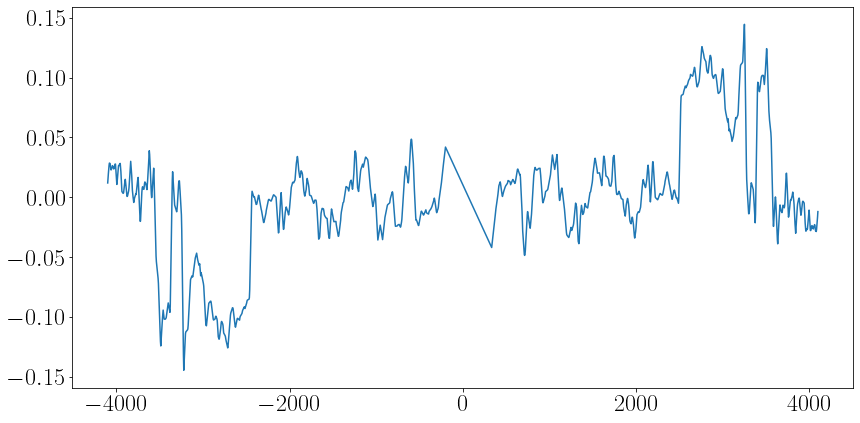

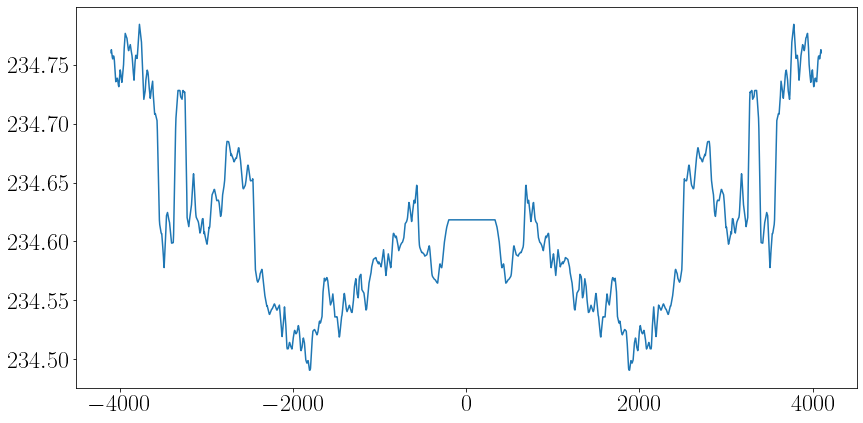

In [4]:
print('Parallel:')
showSAS(xysPar, 'Par')
print('Pependicular:')
showSAS(xysPerp, 'Perp')
print('Transverse:')
showSAS(xysTrans, 'Trans')

Parallel: 2.322589e+02\pm1.100000e-04\,[k\Omega]


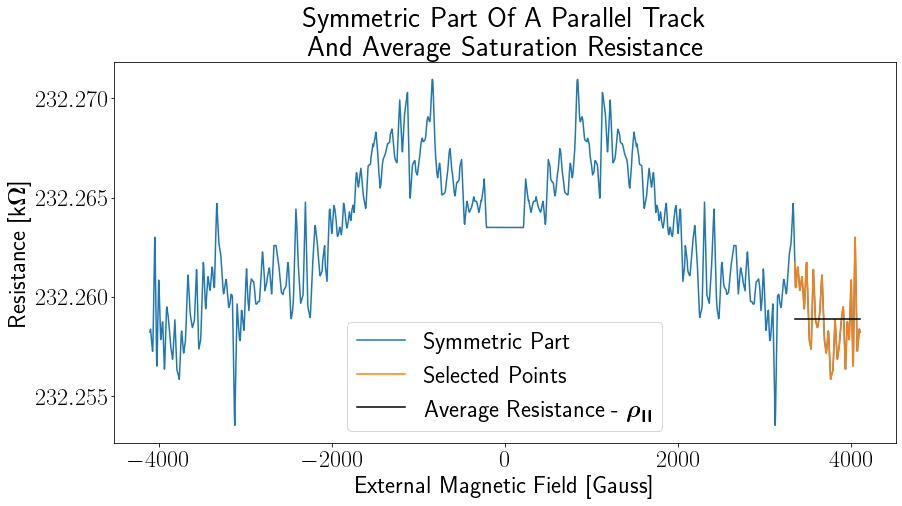

Perpendicular: 2.278818e+02\pm3.100000e-04\,[k\Omega]


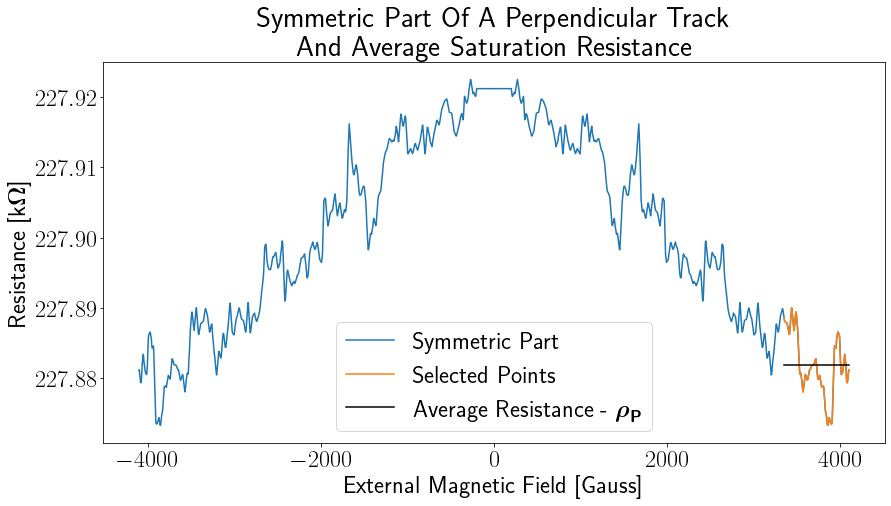

Transverse: 2.347500e+02\pm1.500000e-03\,[k\Omega]


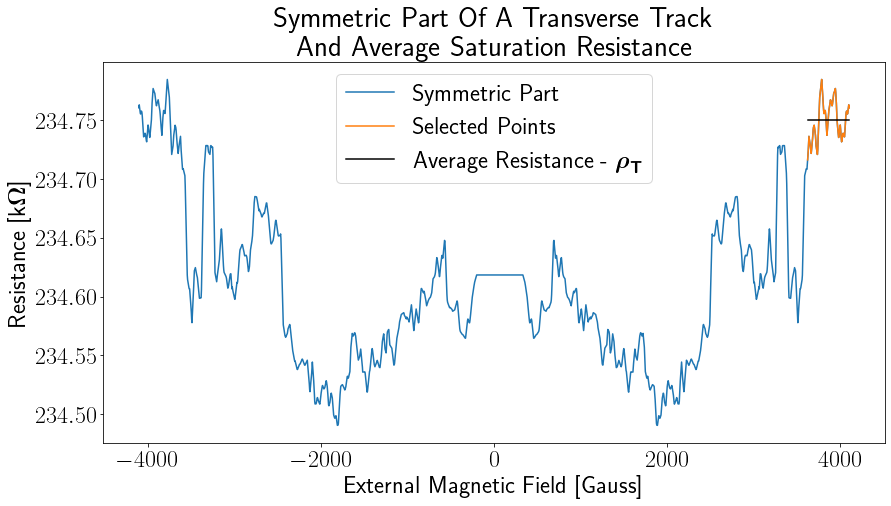

In [5]:
def AvgAtEnd(x, stds=3, wind=20):
    i = 1
    std = 99
    avg = x[-1]
    while i < len(x)//2 and np.abs(x[-i] - avg) < stds*std:
        avg = (x[-i] + avg*i)/(i+1)
        if np.std(x[-i:]):
            if i<=wind:
                std = np.std(x[-i:])
            else:
                std = np.std(x[-i:-i+wind])
        else:
            std = 99
        i += 1
    return avg, std, i

round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

def avgFinder(name, symbol, lst, stds=3, wind=20, smooth=False):
    AsS = Symmon(lst)
    avg, std, i = AvgAtEnd(AsS[1][1], stds, wind)
    std = np.std(AsS[1][1][-i:])
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    if not smooth:
        plt.plot(AsS[1][0],AsS[1][1], label='Symmetric Part')
        plt.plot(AsS[1][0][-i:],AsS[1][1][-i:], label='Selected Points')
        plt.plot(AsS[1][0][-i:], [avg]*i, label=r'Average Resistance - $\boldsymbol\rho_{'+f'{symbol}'+r'}$', c='k')
        plt.title(f'Symmetric Part Of A {name} Track \nAnd Average Saturation Resistance')
        plt.ylabel(r'Resistance [k$\boldsymbol\Omega$]')
        plt.xlabel(r'External Magnetic Field [Gauss]')
        plt.legend()
        std = round_to_n(std/np.sqrt(i),2)
        avg = round(avg, -int(math.floor(math.log10(abs(std)))) + 1)
        print(f'{name}: {avg:e}\\pm{std:e}\\,[k\\Omega]')
        plt.savefig(f'AMR/{name}Resistance.png')
        plt.show()
    if smooth:
        plt.plot(AsS[1][0],AsS[1][1], label='Symmetric Part')
        plt.plot(AsS[1][0][-i:],AsS[1][1][-i:], label='Selected Points')
        plt.plot(AsS[1][0][-i:], [avg]*i, label=r'Average Resistance - $\boldsymbol\rho_{'+f'{symbol}'+r'}$', c='k')
        plt.title(f'Symmetric Part Of A {name} Track \nAnd Average Saturation Resistance')
        plt.ylabel(r'Resistance [k$\boldsymbol\Omega$]')
        plt.xlabel(r'External Magnetic Field [Gauss]')
        plt.legend()
        print(f'{name}: {avg:e}\\pm{std:e}\\,[k\\Omega]')
        plt.savefig(f'AMR/{name}Resistance.png')
        plt.show()

avgFinder('Parallel',r'\textbf{II}', xysPar[0], stds=7, wind=20)
avgFinder('Perpendicular',r'\textbf{P}', xysPerp[0], stds=7, wind=30)
avgFinder('Transverse',r'\textbf{T}', xysTrans[1], stds=4, wind=20)

In [186]:
def Hysteresis(a = 1000, alpha = 9.38e-4, c = 0.0889, k = 483, Ms = 1.48e6, plot=True):
    mu0 = 4 * np.pi * 1e-7 # H/m

    H = [0]
    delta = [0]
    Man = [0]
    dMirrdH = [0]
    Mirr = [0]
    M = [0]

    DeltaH = 20
    Nfirst = 200
    Ndown = 2*Nfirst
    Nup = 2*Nfirst

    for i in range(Nfirst):
        H.append(H[i] + DeltaH)

    for i in range(Ndown):
        H.append(H[-1] - DeltaH)

    for i in range(Nup):
        H.append(H[-1] + DeltaH)

    delta = [0]
    for i in range(len(H) - 1):
        if H[i + 1] > H[i]:
            delta.append(1)
        else:
            delta.append(-1)

    def L(x):
        return (np.cosh(x) / np.sinh(x)) - (1 / x)

    for i in range(Nfirst + Ndown + Nup):
        Man.append(Ms * (1 / np.tanh((H[i + 1] + alpha * M[i]) / a) - a / (H[i + 1] + alpha * M[i])))
        dMirrdH.append((Man[i+1] - M[i]) / (k * delta[i+1] - alpha * (Man[i + 1] - M[i])))
        Mirr.append(Mirr[i] + dMirrdH[i + 1] * (H[i+1] - H[i]))
        M.append(c * Man[i + 1] + (1 - c) * Mirr[i + 1])
    
    if plot:
        plt.plot(H, M)
        plt.show()
    return H, M

def findTracks(regionsLR,LR):
    tracks = np.full(2*len(regionsLR)+1,np.nan)
    solr=np.array(sorted(np.vstack(LR), key= lambda x: x[0]), dtype=int).T
    i=0
    while solr[2,i]==solr[2,i+1]:
        tracks[2*solr[3,i]]=solr[0,i]
        tracks[2*solr[3,i]+1]=solr[1,i]
        i+=1
    tracks[2*solr[3,i]]=solr[0,i]
    tracks[2*solr[3,i]+1]=solr[1,i]
    tracks[-1]=solr[2][i]
    i+=1

    while i<len(solr[2]):
        temp = np.full(2*len(regionsLR)+1,np.nan)
        while i<len(solr[2])-1 and solr[2,i]==solr[2,i+1]:
            temp[2*solr[3,i]]=solr[0,i]
            temp[2*solr[3,i]+1]=solr[1,i]
            i+=1
        temp[2*solr[3,i]]=solr[0,i]
        temp[2*solr[3,i]+1]=solr[1,i]
        temp[-1]=int(solr[2][i])
        tracks = np.vstack((tracks,temp))
        i+=1
    return tracks

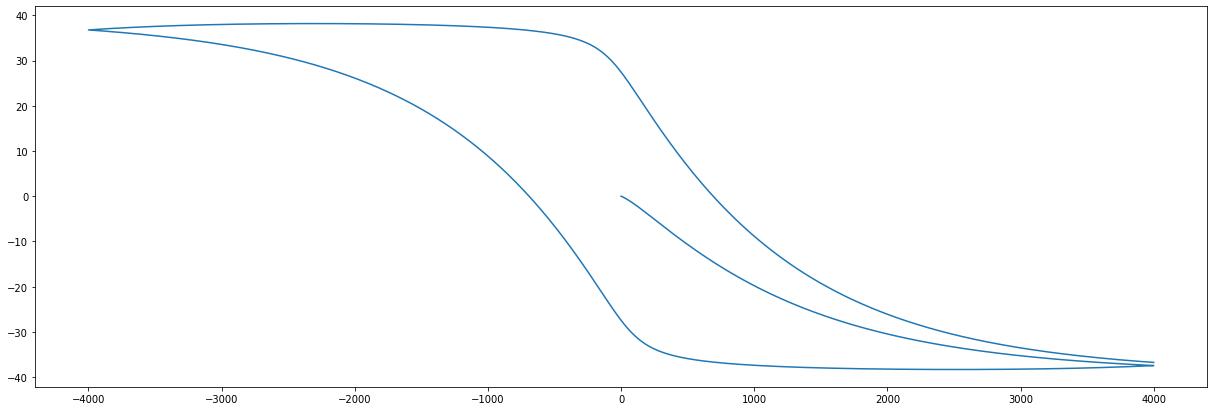

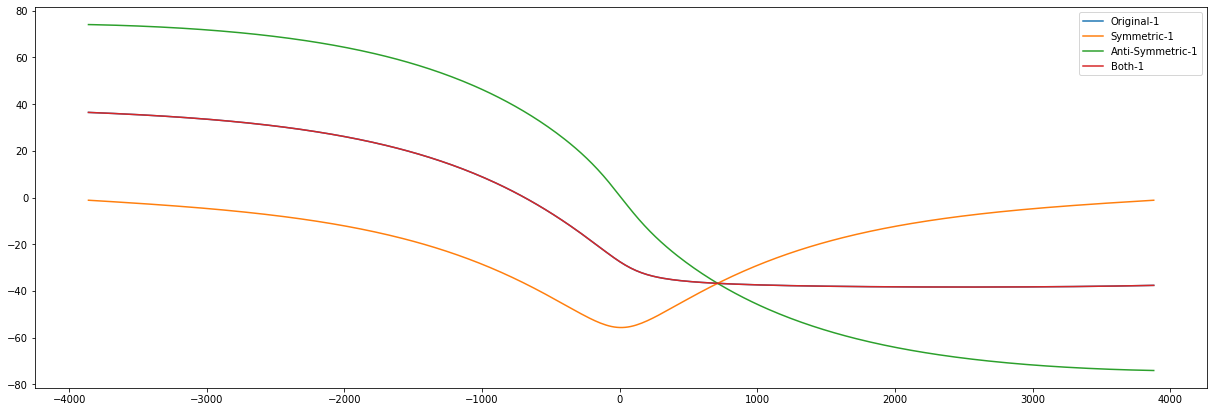

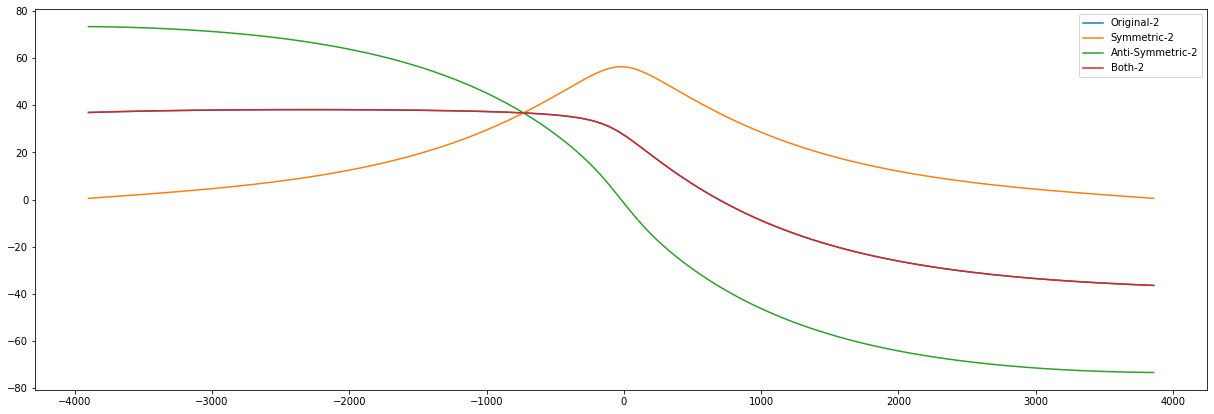

In [251]:
def noNanMinMax(track):
    noNan = track[:-1][~np.isnan(track[:-1])]
    return int(min(noNan)), int(max(noNan))

def Simon(xy):
    sym = np.array([np.hstack((xy[0][0],xy[1][0])),
                         np.hstack((xy[1][1][::-1]+xy[0][1],xy[1][1]+xy[0][1][::-1]))])
    anti_sym = np.array([np.hstack((xy[0][0],xy[1][0])),
                         np.hstack((-xy[1][1][::-1]+xy[0][1],xy[1][1]-xy[0][1][::-1]))])
    return anti_sym, sym

H, M = Hysteresis(a = -100, alpha = 9.38e-5, c = 0.0889, k = 1000, Ms = 40, plot=False)
plt.plot(H,M)
plt.show()
regionsLR = np.array([[-3900,-10], [10,3900]])
tracks = findTracks(regionsLR, findRegions(H,M,regionsLR))

i=1
for track in tracks:
    minn, maxx = noNanMinMax(track)
    x = H[minn:maxx]
    y = M[minn:maxx]
    half = len(x)//2
    leftover = len(x)%2
    xy = np.array([[x[:half],y[:half]],[x[(half+leftover):],y[(half+leftover):]]])
    As, S = Simon(xy)
    plt.plot(x,y, label=f'Original-{i}')
    plt.plot(S[0], S[1], label=f'Symmetric-{i}')
    plt.plot(As[0], As[1], label=f'Anti-Symmetric-{i}')
    plt.plot(As[0], (As[1]+S[1])/2, label=f'Both-{i}')
    i+=1
    plt.legend()    
    plt.show()

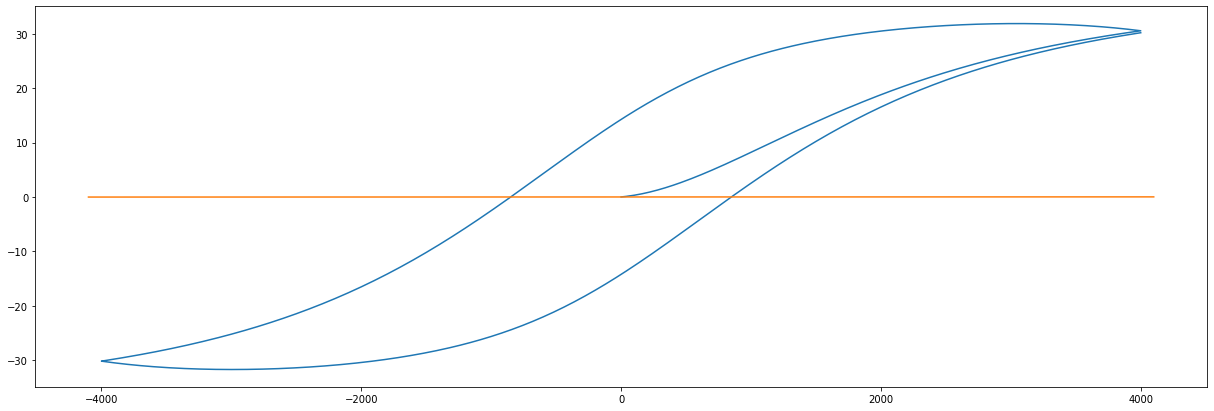

In [233]:
H, M = Hysteresis(a = 600, alpha = 9.38e-5, c = 0.0889, k = 1000, Ms = 40, plot = False)
plt.plot(H,M)
x = np.hstack((xysPar[0][0][0],xysPar[0][1][0]))
y = np.hstack((xysPar[0][0][1],xysPar[0][1][1]))
y = y - sum(y)/len(y)
plt.plot(x,y)
plt.show()